In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data=pd.read_csv('Merged Df.csv') #combined OHLC data
data.drop(axis=1, columns=['Unnamed: 0'], inplace=True)
data

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,2018-07-16,303.451202,303.451202,294.253876,296.100616,290.229248,32424.0,AARTIIND
1,2018-07-17,296.452972,302.843719,292.382812,300.061432,294.111542,37416.0,AARTIIND
2,2018-07-18,300.826874,302.515656,291.981873,295.359497,289.502869,79063.0,AARTIIND
3,2018-07-19,294.023010,297.910919,288.458466,292.662262,286.859131,67536.0,AARTIIND
4,2018-07-20,290.900543,298.834320,290.900543,295.347351,289.490936,31046.0,AARTIIND
...,...,...,...,...,...,...,...,...
191880,2023-07-07,191.100006,208.250000,186.100006,206.149994,206.149994,49451353.0,ZEEL
191881,2023-07-10,207.649994,209.399994,194.449997,201.500000,201.500000,39408934.0,ZEEL
191882,2023-07-11,204.000000,204.550003,198.699997,202.000000,202.000000,10820565.0,ZEEL
191883,2023-07-12,202.100006,204.100006,200.550003,201.949997,201.949997,5488223.0,ZEEL


In [34]:
import pandas as pd

class AlphaCheck:
    """
    This class contains methods for creating and testing alphas (quantitative signals) based on stock data.
    """

    def __init__(self):
        """
        Initializes the AlphaCheck class by loading the dataset and preparing new columns such as returns.
        """
        # Load dataset and clean unnecessary columns
        self.data = pd.read_csv('Merged Df.csv')
        self.data.drop(columns=['Unnamed: 0'], inplace=True)
        self.data.rename(columns={'Close': 'close', 'Open': 'open', 'Low': 'low', 'High': 'high'}, inplace=True)

        # Prepare new columns for each symbol in the dataset
        syms = self.data['Symbol'].unique()  # Unique stock symbols
        data = pd.DataFrame()  # Empty DataFrame for processed data
        
        # Process each symbol's data
        for sym in syms:
            df = self.data[self.data['Symbol'] == sym].copy()

            # Create shifted columns for previous and future close prices
            df['close_1'] = df.close.shift(1)  # Previous day's close
            df['close1'] = df.close.shift(-1)  # Next day's close

            # Handle missing values by filling with the current close
            df['close1'].fillna(df['close'], inplace=True)
            df['close_1'].fillna(df['close'], inplace=True)

            # Calculate various return metrics
            df['ret1'] = df['close1'] / df['close'] - 1  # Future returns
            df['ret_1'] = df['close'] / df['close_1'] - 1  # Current returns
            df['oret'] = df['open'] / df['close_1'] - 1  # Overnight returns
            df['tret'] = df['close'] / df['open'] - 1  # Intraday returns

            # Adjust volume by multiplying with close price
            df['Volume'] = df['Volume'] * df['close']

            # Convert the date column to datetime format
            df['Date'] = pd.to_datetime(df['Date'])

            # Append processed data for the current symbol
            data = pd.concat([df, data], ignore_index=True)

        # Store the processed data in the class instance
        self.data = data.copy()

    def neutralize(self, alpha_col, neut_col='Date', func='mean'):
        """
        Neutralizes the given alpha column by removing the mean or median per group (grouped by neut_col).

        Parameters:
        - alpha_col: Column name of the alpha to be neutralized.
        - neut_col: Column to group by (default is 'Date').
        - func: Neutralization method ('mean' or 'median', default is 'mean').
        """
        df = self.data
        if func == 'median':
            df[alpha_col] = df.groupby(neut_col)[alpha_col].transform(lambda x: x - x.median())
        else:
            df[alpha_col] = df.groupby(neut_col)[alpha_col].transform(lambda x: x - x.mean())

    def bucketed_prop(self, alpha_col, bckt_col='Volume', func='mean', buckets=10, clip=False, clip_perc=0.975):
        """
        Returns the bucketed properties (mean/median/std) of the alpha in different volume or date buckets.

        Parameters:
        - alpha_col: The alpha column to analyze.
        - bckt_col: The column to use for bucketing (default is 'Volume').
        - func: The aggregation function to use ('mean', 'median', 'std', default is 'mean').
        - buckets: Number of buckets to divide the data into (default is 10).
        - clip: Whether to clip extreme values (default is False).
        - clip_perc: Clipping percentile (default is 0.975).
        """
        df = self.data.copy()

        # Divide the data into quantile-based buckets
        df[f'Bckt_{bckt_col}'] = pd.qcut(df[bckt_col], buckets)

        if func == 'median':
            return df.groupby(f'Bckt_{bckt_col}')[alpha_col].median()
        if func == 'std':
            return df.groupby(f'Bckt_{bckt_col}')[alpha_col].std()
        return df.groupby(f'Bckt_{bckt_col}')[alpha_col].mean()

    def check_corr(self, alpha_col, return_col, bckt_col='Volume', buckets=10):
        """
        Returns the bucketed correlations of the given alpha with future returns.

        Parameters:
        - alpha_col: The alpha column(s) to check correlation for.
        - return_col: The column representing future returns.
        - bckt_col: The column to use for bucketing (default is 'Volume').
        - buckets: Number of buckets (default is 10).
        """
        df = self.data.copy()

        # Divide the data into quantile-based buckets
        df[f'Bucket_{bckt_col}'] = pd.qcut(df[bckt_col], buckets)

        # Dictionary to store correlations for each alpha
        correlations = {}

        # Function to calculate correlation for each group
        def calculate_corr(group, alpha_col):
            return group[alpha_col].corr(group[return_col])

        # Apply the correlation calculation for each alpha column
        for col in alpha_col:
            correlations[col] = df.groupby(f'Bucket_{bckt_col}').apply(calculate_corr, col)

        return correlations

    def alphaZone(self):
        """
        Creates new alphas (alpha_1, alpha_2, alpha_3, alpha_4) based on specific formulas and stores them in the DataFrame.
        """
        df = self.data

        # Create alphas based on the provided formulas
        df['alpha_1'] = -1 * (df['Volume'] - df['Volume'].shift(1)) * (df['close'] - df['close_1']) / df['close']
        df['alpha_2'] = -1 * (df['close'] / (df['close_1'] + df['close_1'].rolling(window=10).std()))
        df['alpha_3'] = -1 * (df['ret_1']) * df['close'].rolling(window=10).std() * (df['Volume'] - df['Volume'].shift(1))
        df['alpha_3'] = (df['alpha_3'] - df['alpha_3'].mean()) / (df['alpha_3'].max() - df['alpha_3'].min())
        df['alpha_4'] = -1 * (df['low'] - df['close']) * df['open'] ** 5 / ((df['low'] - df['high']) * df['close'] ** 5)

        # Handle missing values by filling with zeros
        df['alpha_1'].fillna(0, inplace=True)
        df['alpha_2'].fillna(0, inplace=True)
        df['alpha_3'].fillna(0, inplace=True)
        df['alpha_4'].fillna(0, inplace=True)

    def ret_df(self):
        """
        Returns the final DataFrame with the newly created alphas and other calculated columns.
        """
        return self.data

# Instantiate the AlphaCheck class
alpha = AlphaCheck()


In [35]:
alpha.alphaZone()
data=alpha.ret_df()
data

,Date,open,high,low,close,Adj Close,Volume,Symbol,close_1,close1,ret1,ret_1,oret,tret,alpha_1,alpha_2,alpha_3,alpha_4
0,2018-07-16,509.500000,518.599976,504.649994,508.049988,489.743408,1.216113e+09,ZEEL,508.049988,516.849976,0.017321,0.000000,0.002854,-0.002846,0.000000e+00,0.000000,0.000000,-0.247225
1,2018-07-17,511.850006,521.900024,507.049988,516.849976,498.226288,1.958478e+09,ZEEL,508.049988,520.900024,0.007836,0.017321,0.007480,0.009768,-1.263966e+07,0.000000,0.000000,-0.628621
2,2018-07-18,519.500000,532.700012,513.049988,520.900024,502.130432,3.643500e+09,ZEEL,516.849976,521.849976,0.001824,0.007836,0.005127,0.002695,-1.310121e+07,0.000000,0.000000,-0.394153
3,2018-07-19,522.299988,526.099976,513.299988,521.849976,503.046112,9.284703e+08,ZEEL,520.900024,514.349976,-0.014372,0.001824,0.002688,-0.000862,4.942317e+06,0.000000,0.000000,-0.670853
4,2018-07-20,518.950012,521.849976,510.600006,514.349976,495.816376,5.522298e+08,ZEEL,521.849976,514.549988,0.000389,-0.014372,-0.005557,-0.008864,-5.486155e+06,0.000000,0.000000,-0.348506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191880,2023-07-10,475.000000,476.000000,452.399994,454.100006,454.100006,1.572599e+09,AARTIIND,472.100006,449.200012,-0.010791,-0.038128,0.006143,-0.044000,3.283498e+05,-0.937416,0.000056,-0.090209
191881,2023-07-11,454.000000,458.600006,447.750000,449.200012,449.200012,1.022969e+09,AARTIIND,454.100006,455.500000,0.014025,-0.010791,-0.000220,-0.010573,-5.995518e+06,-0.951448,0.000036,-0.140936
191882,2023-07-12,451.850006,457.500000,448.500000,455.500000,455.500000,8.199232e+08,AARTIIND,449.200012,448.299988,-0.015807,0.014025,0.005899,0.008078,2.808306e+06,-0.967761,0.000064,-0.747111
191883,2023-07-13,456.100006,456.649994,445.000000,448.299988,448.299988,5.716937e+08,AARTIIND,455.500000,453.299988,0.011153,-0.015807,0.001317,-0.017102,-3.986741e+06,-0.938814,0.000042,-0.308776


In [36]:
alpha.neutralize('alpha_2')
alpha.bucketed_prop('alpha_2', 'Volume', func='std') #checking standard dev.(volatility) of alpha_2 in diff volume buckets.

Bckt_Volume
(-0.001, 215425258.288]               0.043991
(215425258.288, 417478618.887]        0.036587
(417478618.887, 623180455.329]        0.039684
(623180455.329, 854464617.659]        0.037709
(854464617.659, 1138403104.843]       0.037240
(1138403104.843, 1513860966.111]      0.037102
(1513860966.111, 2078644306.897]      0.035197
(2078644306.897, 3069427546.49]       0.037366
(3069427546.49, 5382029563.645]       0.038250
(5382029563.645, 369863777217.926]    0.042760
Name: alpha_2, dtype: float64

In [37]:
alpha.check_corr(['alpha_1','alpha_2','alpha_3','alpha_4'], 'ret1', bckt_col='Volume',buckets=4) #checking corr of multiple alphas in diff volume buckets with future returns(ret1)

{'alpha_1': Bucket_Volume
 (-0.001, 518431569.426]               0.000783
 (518431569.426, 1138403104.843]      -0.001535
 (1138403104.843, 2499567284.176]     -0.004824
 (2499567284.176, 369863777217.926]    0.007458
 dtype: float64,
 'alpha_2': Bucket_Volume
 (-0.001, 518431569.426]               0.000322
 (518431569.426, 1138403104.843]       0.005960
 (1138403104.843, 2499567284.176]      0.003411
 (2499567284.176, 369863777217.926]   -0.000596
 dtype: float64,
 'alpha_3': Bucket_Volume
 (-0.001, 518431569.426]               0.000686
 (518431569.426, 1138403104.843]      -0.002325
 (1138403104.843, 2499567284.176]     -0.008755
 (2499567284.176, 369863777217.926]    0.001671
 dtype: float64,
 'alpha_4': Bucket_Volume
 (-0.001, 518431569.426]              -0.021137
 (518431569.426, 1138403104.843]      -0.020412
 (1138403104.843, 2499567284.176]     -0.009031
 (2499567284.176, 369863777217.926]   -0.001702
 dtype: float64}

In [51]:
import pandas as pd
from sklearn.cluster import KMeans

class SectorClass:
    """
    This class performs sector clustering, momentum calculation, and correlation checks based on the alphas generated from stock data.
    """

    def __init__(self):
        """
        Initializes the SectorClass by accessing and preparing the alpha data from the AlphaCheck class.
        """
        # Create an instance of AlphaCheck and process the alphas
        alpha = AlphaCheck()
        alpha.alphaZone()
        alpha.neutralize('ret_1')
        self.data = alpha.ret_df()

    def alpha_matrix(self, alpha_col):
        """
        Creates a matrix where rows represent stock symbols, columns represent dates, and values are the specified alpha values.

        Parameters:
        - alpha_col: The column name of the alpha values to use for the matrix.
        
        Returns:
        - A DataFrame with symbols as rows and dates as columns, containing the alpha values.
        """
        dict1 = {}
        
        # Create a dictionary with symbols as keys and alpha values as time series
        for sym in self.data.Symbol.unique():
            df1 = self.data[self.data['Symbol'] == sym]
            dict1[sym] = dict(zip(df1.Date, df1[alpha_col]))
        
        # Create a DataFrame from the dictionary
        matrix = pd.DataFrame(dict1).T
        
        # Drop columns with too many missing values and fill the remaining NaNs with 0
        for cols in matrix.columns.sort_values():
            if matrix[cols].isna().sum() > 60:
                matrix.drop(columns=[cols], inplace=True)
            matrix = matrix.fillna(0)
        
        return matrix

    def cluster_matrix(self, alpha_col='ret_1', look_back=100, n_clusters=13):
        """
        Performs K-Means clustering on the alpha matrix and returns a matrix with cluster labels.

        Parameters:
        - alpha_col: The alpha column to use for clustering (default is 'ret_1').
        - look_back: Number of previous days to use for clustering (default is 100).
        - n_clusters: Number of clusters (default is 13).
        
        Returns:
        - A DataFrame with cluster labels for each symbol over time.
        """
        # Initialize K-Means model
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
        
        # Create the alpha matrix
        df1 = self.alpha_matrix(alpha_col)
        columns = df1.columns
        
        # Perform clustering using the look-back window
        for col_idx in range(len(columns) - 1, look_back, -1):
            X = df1.iloc[:, col_idx - look_back:col_idx]
            y_clusters = kmeans.fit_predict(X)
            df1[columns[col_idx]] = y_clusters
        
        # Store the cluster labels
        self.cluster = df1.iloc[:, look_back + 1:]
        return df1.iloc[:, look_back + 1:]

    def get_clusters(self, df, date):
        """
        Returns the clusters and their corresponding symbols for a given date.
        
        Parameters:
        - df: The DataFrame containing the cluster labels.
        - date: The specific date to retrieve clusters for.
        
        Returns:
        - A dictionary where keys are cluster labels and values are lists of symbols in each cluster.
        """
        df1 = self.cluster_matrix()
        clusters = df1[date].unique()
        cluster_dict = {}
        
        # Group symbols by their cluster labels for the given date
        for i in clusters:
            cluster_dict[i] = df1[df1[date] == i].index.to_list()
        
        return cluster_dict

    def new_matrix(self):
        """
        Combines the cluster labels into the original DataFrame.
        
        Returns:
        - A DataFrame containing the stock data along with the corresponding cluster labels.
        """
        def find_uncommon_elements(list1, list2):
            """
            Helper function to find uncommon elements between two lists.
            """
            set1 = set(list1)
            set2 = set(list2)
            uncommon_elements = set1.symmetric_difference(set2)
            return list(uncommon_elements)
        
        date_cols = self.cluster.columns
        new_df = pd.DataFrame()
        
        # Combine cluster labels with the original DataFrame for each date
        for date in date_cols:
            temp_df = self.data[self.data['Date'] == date]
            syms1 = list(self.cluster[date].index)
            syms2 = list(self.data[self.data['Date'] == date]['Symbol'])
            del_syms = find_uncommon_elements(syms1, syms2)
            temp_df['Cluster'] = self.cluster.drop(del_syms)[date].values
            new_df = pd.concat([temp_df, new_df], ignore_index=True)
        
        self.new_df = new_df
        return new_df

    def mom_matrix(self):
        """
        Calculates sector momentum and residuals for each stock based on its cluster.
        
        Returns:
        - A DataFrame with sector momentum and residual columns.
        """
        matrix1 = self.new_df
        matrix1['Sec_Mom'] = 0
        
        # Calculate sector momentum for each date and cluster
        for date in matrix1['Date'].unique():
            temp = matrix1[matrix1['Date'] == date]
            grp = temp.groupby('Cluster')['ret_1'].mean()
            sec_mom = [(index_val, mom_val) for index_val, mom_val in grp.items()]
            
            # Assign sector momentum to each stock
            for sec, mom in sec_mom:
                matrix1.loc[(matrix1['Cluster'] == sec) & (matrix1['Date'] == date), 'Sec_Mom'] = mom
        
        # Calculate the residual (actual return minus sector momentum)
        matrix1['Residual'] = matrix1['ret_1'] - matrix1['Sec_Mom']
        self.matrix = matrix1
        return matrix1

    def check_corr(self, alpha_col, return_col, bckt_col='Volume', buckets=10):
        """
        Returns the correlation of the sector momentum with future returns, bucketed by a specific column.

        Parameters:
        - alpha_col: The alpha column(s) to check correlation for.
        - return_col: The column representing future returns.
        - bckt_col: The column to use for bucketing (default is 'Volume').
        - buckets: Number of buckets (default is 10).
        
        Returns:
        - A dictionary of correlations between the sector momentum and future returns.
        """
        df = self.matrix
        df[f'Bucket_{bckt_col}'] = pd.qcut(df[bckt_col], buckets)
        correlations = {}

        # Function to calculate correlation for each group
        def calculate_corr(group, alpha_col):
            return group[alpha_col].corr(group[return_col])

        # Apply the correlation calculation for each alpha column
        for col in alpha_col:
            correlations[col] = df.groupby(f'Bucket_{bckt_col}').apply(calculate_corr, col)

        return correlations

# Instantiate the SectorClass
sc = SectorClass()


In [52]:
clstr=sc.cluster_matrix()
temp_df=sc.new_matrix()
mom_df=sc.mom_matrix()

In [60]:
sc.check_corr(['Sec_Mom','Residual','ret_1'],'ret1',bckt_col='Volume',buckets=5)

{'Sec_Mom': Bucket_Volume
 (-0.001, 437578231.269]              -0.000242
 (437578231.269, 881570448.525]        0.005754
 (881570448.525, 1555081195.144]       0.006716
 (1555081195.144, 3156546791.797]      0.019332
 (3156546791.797, 369863777217.926]    0.010791
 dtype: float64,
 'Residual': Bucket_Volume
 (-0.001, 437578231.269]              -0.011672
 (437578231.269, 881570448.525]       -0.004559
 (881570448.525, 1555081195.144]       0.000225
 (1555081195.144, 3156546791.797]     -0.003755
 (3156546791.797, 369863777217.926]    0.008443
 dtype: float64,
 'ret_1': Bucket_Volume
 (-0.001, 437578231.269]              -0.011023
 (437578231.269, 881570448.525]       -0.001446
 (881570448.525, 1555081195.144]       0.003438
 (1555081195.144, 3156546791.797]      0.005775
 (3156546791.797, 369863777217.926]    0.012241
 dtype: float64}

<AxesSubplot: >

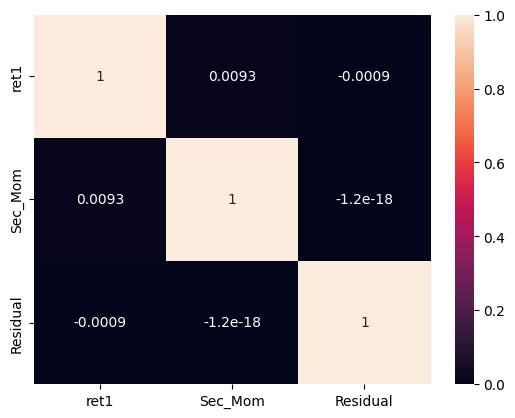

In [66]:
sns.heatmap(mom_df[['ret1','Sec_Mom','Residual']].corr(), annot=True)